In [13]:
import pickle
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.generation.sampling import MaxPosteriorSampling
import matplotlib.ticker as ticker

from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import KernelDensity

from torch.utils.data import DataLoader, TensorDataset
from torch.quasirandom import SobolEngine

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from examples.SMO.test_functions import functions, bounds as boundsx
# from uncertaintylearning.utils.feature_generator import FeatureGenerator
# from uncertaintylearning.utils.density_estimator import FixedSmoothKernelDensityEstimator
# from uncertaintylearning.utils.density_picker import CrossValidator
# from uncertaintylearning.utils.buffer import Buffer
# from uncertaintylearning.utils.smo import init_buffer, optimize, make_feature_generator, one_step_acquisition

from copy import deepcopy
from itertools import product
functions

{'sinusoid': <function examples.SMO.test_functions.sinusoid(X, noise)>,
 'multi_optima': <function examples.SMO.test_functions.multi_optima(X, noise)>,
 'booth': <function examples.SMO.test_functions.booth(X, noise)>,
 'levi_n13': <function examples.SMO.test_functions.levi_n13(X, noise)>,
 'ackley200': <function examples.SMO.test_functions.ackley200(X, noise)>,
 'ackley10': <function examples.SMO.test_functions.ackley10(X, noise)>}

## multi_optima_fct

In [9]:
fct_name = 'multi_optima'
fct = functions[fct_name]
dim, bounds = boundsx[fct_name]
noise = 0
f = lambda x: fct(x, 0)
x = torch.linspace(-1, 2, 1000).unsqueeze(-1)

In [10]:
results = pickle.load(open('pickles/multi_optima.pkl', 'rb'))
n_steps = 50

In [11]:
x_random = torch.zeros((56, 500)).uniform_(-1, 2)
y_random = f(x_random)
random_acq = np.maximum.accumulate(y_random, axis=0).numpy().T[:, -51:]
random_acq.shape


(500, 51)

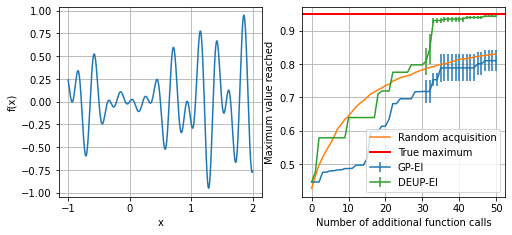

In [12]:

fig, axes = plt.subplots(1, 2, figsize = (8, 3.5))
axes[0].plot(x, f(x).squeeze())
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[0].grid()
axes[1].errorbar(range(1 + n_steps), results['gp'].mean(0), results['gp'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='GP-EI')
axes[1].plot(range(1 + n_steps), random_acq.mean(0), label='Random acquisition')

axes[1].errorbar(range(1 + n_steps), results['gpdeup'].mean(0), results['gpdeup'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='DEUP-EI')
axes[1].axhline(f(x).max(), linewidth=2, color='r', label='True maximum')
axes[1].legend()
axes[1].set_xlabel("Number of additional function calls")
axes[1].set_ylabel("Maximum value reached")
axes[1].grid()
plt.savefig('figs/multioptima_results_new.pdf')

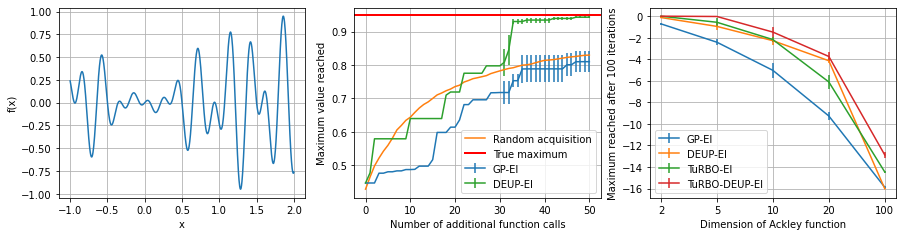

In [20]:
# PLOT with Ackley in the same row
res = pickle.load(open('pickles/ackleyloop.pkl', 'rb'))

fig, axes = plt.subplots(1, 3, figsize = (15, 3.5))
axes[0].plot(x, f(x).squeeze())
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[0].grid()
axes[1].errorbar(range(1 + n_steps), results['gp'].mean(0), results['gp'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='GP-EI')
axes[1].plot(range(1 + n_steps), random_acq.mean(0), label='Random acquisition')

axes[1].errorbar(range(1 + n_steps), results['gpdeup'].mean(0), results['gpdeup'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='DEUP-EI')
axes[1].axhline(f(x).max(), linewidth=2, color='r', label='True maximum')
axes[1].legend()
axes[1].set_xlabel("Number of additional function calls")
axes[1].set_ylabel("Maximum value reached")
axes[1].grid()

dims = (2, 5, 10, 20, 100)
labels = {'gp' : 'GP-EI', 'deup': 'DEUP-EI', 'turbo_gp': 'TuRBO-EI', 'turbo_deup': 'TuRBO-DEUP-EI'}
plt.rcParams["figure.figsize"] = (8, 8)
all_res = {key: lambda dim: res[key][dim][:, -1] for key in res.keys()}

for key in res.keys():
    tmp = np.array([res[key][dim][:, -1] for dim in (2,5,10,20,100)])
    axes[2].errorbar(range(len(dims)), tmp.mean(1), tmp.std(1) / np.sqrt(3), label=labels[key])

plt.legend()
# labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [0, 2, 5, 10, 20, 100]
axes[2].xaxis.set_major_locator(ticker.MultipleLocator(1))
axes[2].set_xticklabels(labels)
axes[2].set_xlabel('Dimension of Ackley function')
axes[2].set_ylabel('Maximum reached after 100 iterations')
axes[2].grid()

plt.savefig('figs/multioptima_results_full.pdf')

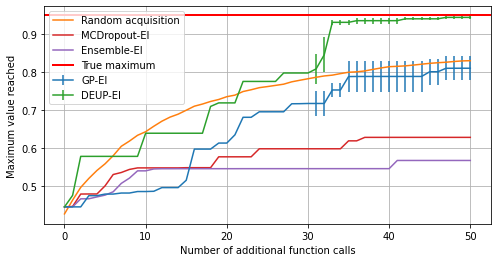

In [21]:
# APPENDIX PLOT with all methods
plt.figure(figsize = (8, 4))
plt.errorbar(range(1 + n_steps), results['gp'].mean(0), results['gp'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='GP-EI')
plt.plot(range(1 + n_steps), random_acq.mean(0), label='Random acquisition')
plt.errorbar(range(1 + n_steps), results['gpdeup'].mean(0), results['gpdeup'].std(0) * (np.arange(51) > 30) / np.sqrt(5), label='DEUP-EI')
plt.plot(range(1 + n_steps), results['mcdropout'].mean(0), label='MCDropout-EI')
plt.plot(range(1 + n_steps), results['ensemble'].mean(0), label='Ensemble-EI')
plt.axhline(f(x).max().item(), linewidth=2, color='r', label='True maximum')
plt.legend()
plt.grid()
plt.xlabel("Number of additional function calls")
plt.ylabel("Maximum value reached")
plt.savefig('figs/multioptima_results_appendix.pdf')
plt.show()

## Ackley

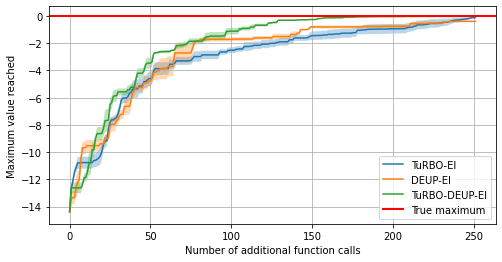

In [34]:
plt.figure(figsize = (8, 4))

ackley_res = pickle.load(open('pickles/turbodeup.pkl', 'rb'))
labels = {'gp': 'GP-EI', 'turbo_gp': 'TuRBO-EI', 'deup_v': 'DEUP-EI', 'turbo_deup_v': 'TuRBO-DEUP-EI'}
for k, v in ackley_res.items():
        if k != 'deup_xv':
            # plt.errorbar(range(v.shape[1]), np.mean(v, axis=0), .5 * np.std(v, axis=0), label=labels[k])
            plt.plot(range(v.shape[1]), np.mean(v, axis=0), label=labels[k])
            plt.fill_between(range(v.shape[1]), np.mean(v, axis=0) -  .5 * np.std(v, axis=0), np.mean(v, axis=0) +.5 * np.std(v, axis=0),
                            alpha=.3)
plt.axhline(0, linewidth=2, color='r', label='True maximum')
plt.legend()
plt.xlabel("Number of additional function calls")
plt.ylabel("Maximum value reached")
plt.grid()
plt.savefig('figs/ackley_results_appendix.pdf')
plt.show()

## LEVI N 13 FUNCTION

In [164]:
fct_name = 'levi_n13'
fct = functions[fct_name]
dim, bounds = boundsx[fct_name]
noise = 0
f = lambda x: fct(x, 0)
results = pickle.load(open('pickles/levi_n13_large.pkl', 'rb'))
n_steps = 50

In [171]:
x_random = torch.zeros((56, 50, 2)).uniform_(-10, 10)
y_random = f(x_random.view(-1, x_random.size(-1))).view(x_random.size(0), x_random.size(1))
random_acq = np.maximum.accumulate(y_random, axis=0).numpy().T[:, -51:]
random_acq.shape


(50, 51)

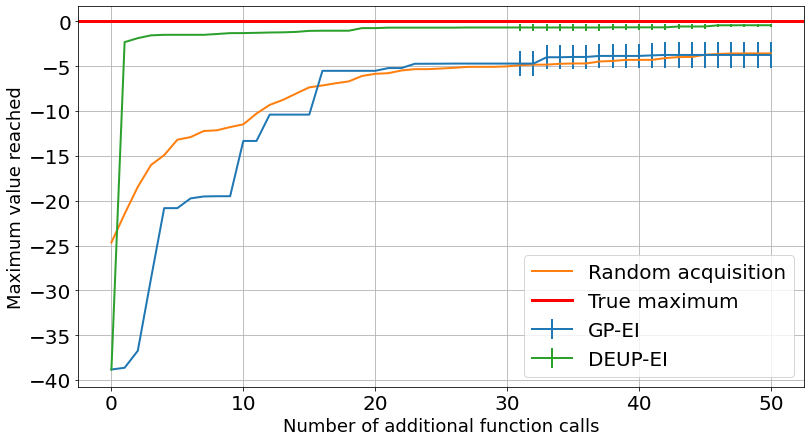

In [199]:
plt.figure(figsize = (13, 7))
plt.errorbar(range(1 + n_steps), results['gp'].mean(0), results['gp'].std(0) * (np.arange(51) > 30) / np.sqrt(5),
             linewidth=2, label='GP-EI')
plt.plot(range(1 + n_steps), random_acq.mean(0), linewidth=2, label='Random acquisition')
plt.errorbar(range(1 + n_steps), results['gpdeup'].mean(0), results['gpdeup'].std(0) * (np.arange(51) > 30) / np.sqrt(5),
             linewidth=2, label='DEUP-EI')
plt.axhline(0, linewidth=3, color='r', label='True maximum')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(prop={'size': 20})
plt.grid()
plt.xlabel("Number of additional function calls", fontsize=18)
plt.ylabel("Maximum value reached", fontsize=18)
plt.savefig('figs/levi_n13_results_appendix.pdf')
plt.show()

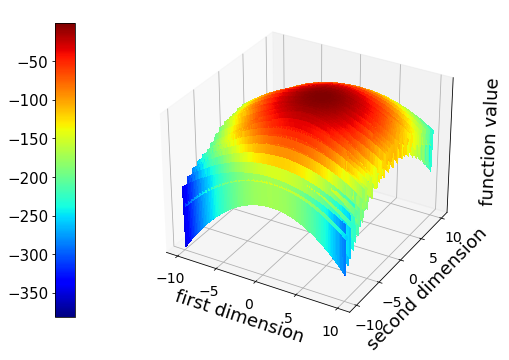

In [206]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
def func(x,y, noise):
    return noise * torch.randn(x.size(0)) - (torch.sin(3 * np.pi * x) ** 2 +
                                                (x - 1) ** 2 * (1 + torch.sin(3 * np.pi * y) ** 2) +
                                                (y - 1) ** 2 * (1 + torch.sin(2 * np.pi * y) ** 2))

bounds = (-10, 10)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
# plot a 3D surface like in the example mplot3d/surface3d_demo
#ax = fig.gca(projection='3d')
X = torch.linspace(*bounds, 100)
Y = torch.linspace(*bounds, 100)
X, Y = torch.meshgrid(X, Y)
Z = func(X, Y, 0)
X = X.numpy()
Y = Y.numpy()
Z = Z.numpy()
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('first dimension', fontsize=18)
ax.set_ylabel('second dimension', fontsize=18)
ax.set_zlabel('function value', fontsize=18)
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.set_zticks([])

cbar = fig.colorbar(surf, aspect=15, ax=[ax], location='left', shrink=0.9)
cbar.ax.tick_params(labelsize=15)
plt.savefig('figs/levi3d.pdf')
plt.show()